# A Case Study : Organosilicon Compounds

In [1]:
parameters = dict(
    subfrag_size = 12,
    edge_size = 3,
    out_size = 1,
    seed = 42,
    batch_size = 256,
    max_epoch = 200,
    verbose = True,
    save = False,
    
    target = 'HCOM',
    hidden_size = 256,
    dropout = 0.276,
    num_layers = 7,
    num_timesteps = 4,
    lr_init = 0.0001,
    gamma = 0.986,
    weight_decay = 6.72E-3,
)
DATAPATH = "/SSD2/bgkang/Chemomile"
MODELPATH = "../Model/HCOM-2024-07-17-04-48-42" # HCOM

In [2]:
# SMILES = "CCCO[Si](C=C)(OCCC)OCCC"; TRUE_VAL = -7.055 # Vinyltripropoxysilane [1]
# SMILES = "CO[Si](CCCOCC1CO1)(OC)OC"; TRUE_VAL = -5.930 # 3-glycidoxypropyltrimethoxysilane [9]
# SMILES = "CCO[Si](CCCN)(OCC)OCC"; TRUE_VAL = -6.290 # (3-Aminopropyl)triethoxysilane [9]
SMILES = "CC(=C)C(=O)OCCC[Si](Cl)(Cl)Cl"; TRUE_VAL = -4.074 # 3-methacryloxypropyltrichlorosilane [9]
# SMILES = "O(C)[Si](OC)(OC)CCCSSCCC[Si](OC)(OC)OC"; TRUE_VAL = -8.811 # Bis[3-trimethoxysilylpropyl]disulfide [0]
# SMILES = "C[Si](C)(C)OC1=CC=CC=C1"; TRUE_VAL = -5.733 # Trimethylphenoxysilane [1]

# [1] : Appl Organomet Chem, 31 (8) (2017), p. e3668
# [9] : J Loss Prev Process Ind, 3 (3) (1990), pp. 311-320

In [3]:
import sys
sys.path.append(DATAPATH)
import numpy as np
import torch
import matplotlib.pyplot as plt
import networkx as nx

from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx

from src.data import Dataset
from src.smiles2data import smiles2data
from src.model import Chemomile
from src.explainer import Explainer

dataset = Dataset(target = parameters['target'],
                  root = DATAPATH)
data = smiles2data(SMILES, TRUE_VAL)

model = Chemomile(
            subfrag_size = parameters['subfrag_size'],
            hidden_size = parameters['hidden_size'],
            out_size = parameters['out_size'],
            edge_size = parameters['edge_size'],
            dropout = parameters['dropout'],
            num_layers = parameters['num_layers'],
            num_timesteps = parameters['num_timesteps'],
            )
model.load_state_dict(torch.load(MODELPATH))
model.eval()

	DataDump found for 'HCOM'. Loading dumped data.
Training : 727 | Validation : 91 | Test : 91
Total : 909


Chemomile(
  (atom_encoder): Sequential(
    (0): Linear(in_features=12, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (subfrag_level): AttentiveFP(in_channels=256, hidden_channels=512, out_channels=256, edge_dim=3, num_layers=7, num_timesteps=4)
  (fragment_level): AttentiveFP(in_channels=256, hidden_channels=512, out_channels=256, edge_dim=3, num_layers=7, num_timesteps=4)
  (molecule_level): AttentiveFP(in_channels=256, hidden_channels=512, out_channels=256, edge_dim=3, num_layers=7, num_timesteps=4)
  (fully_connected): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.276, inplace=False)
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [4]:
explainer = Explainer(
    model = model,
    data = data
)

pred = explainer.ref * dataset.std + dataset.mean

nameset = [data.smiles for data in dataset.total_set]

if SMILES in nameset:
    print(f"{SMILES} is already in the dataset.")
print(f"| SMILES : {data.smiles} | TRUE : {data.y:.3f} | PRED : {pred:.3f} |")

score = explainer.atomMask()

| SMILES : CC(=C)C(=O)OCCC[Si](Cl)(Cl)Cl | TRUE : -4.074 | PRED : -3.251 |


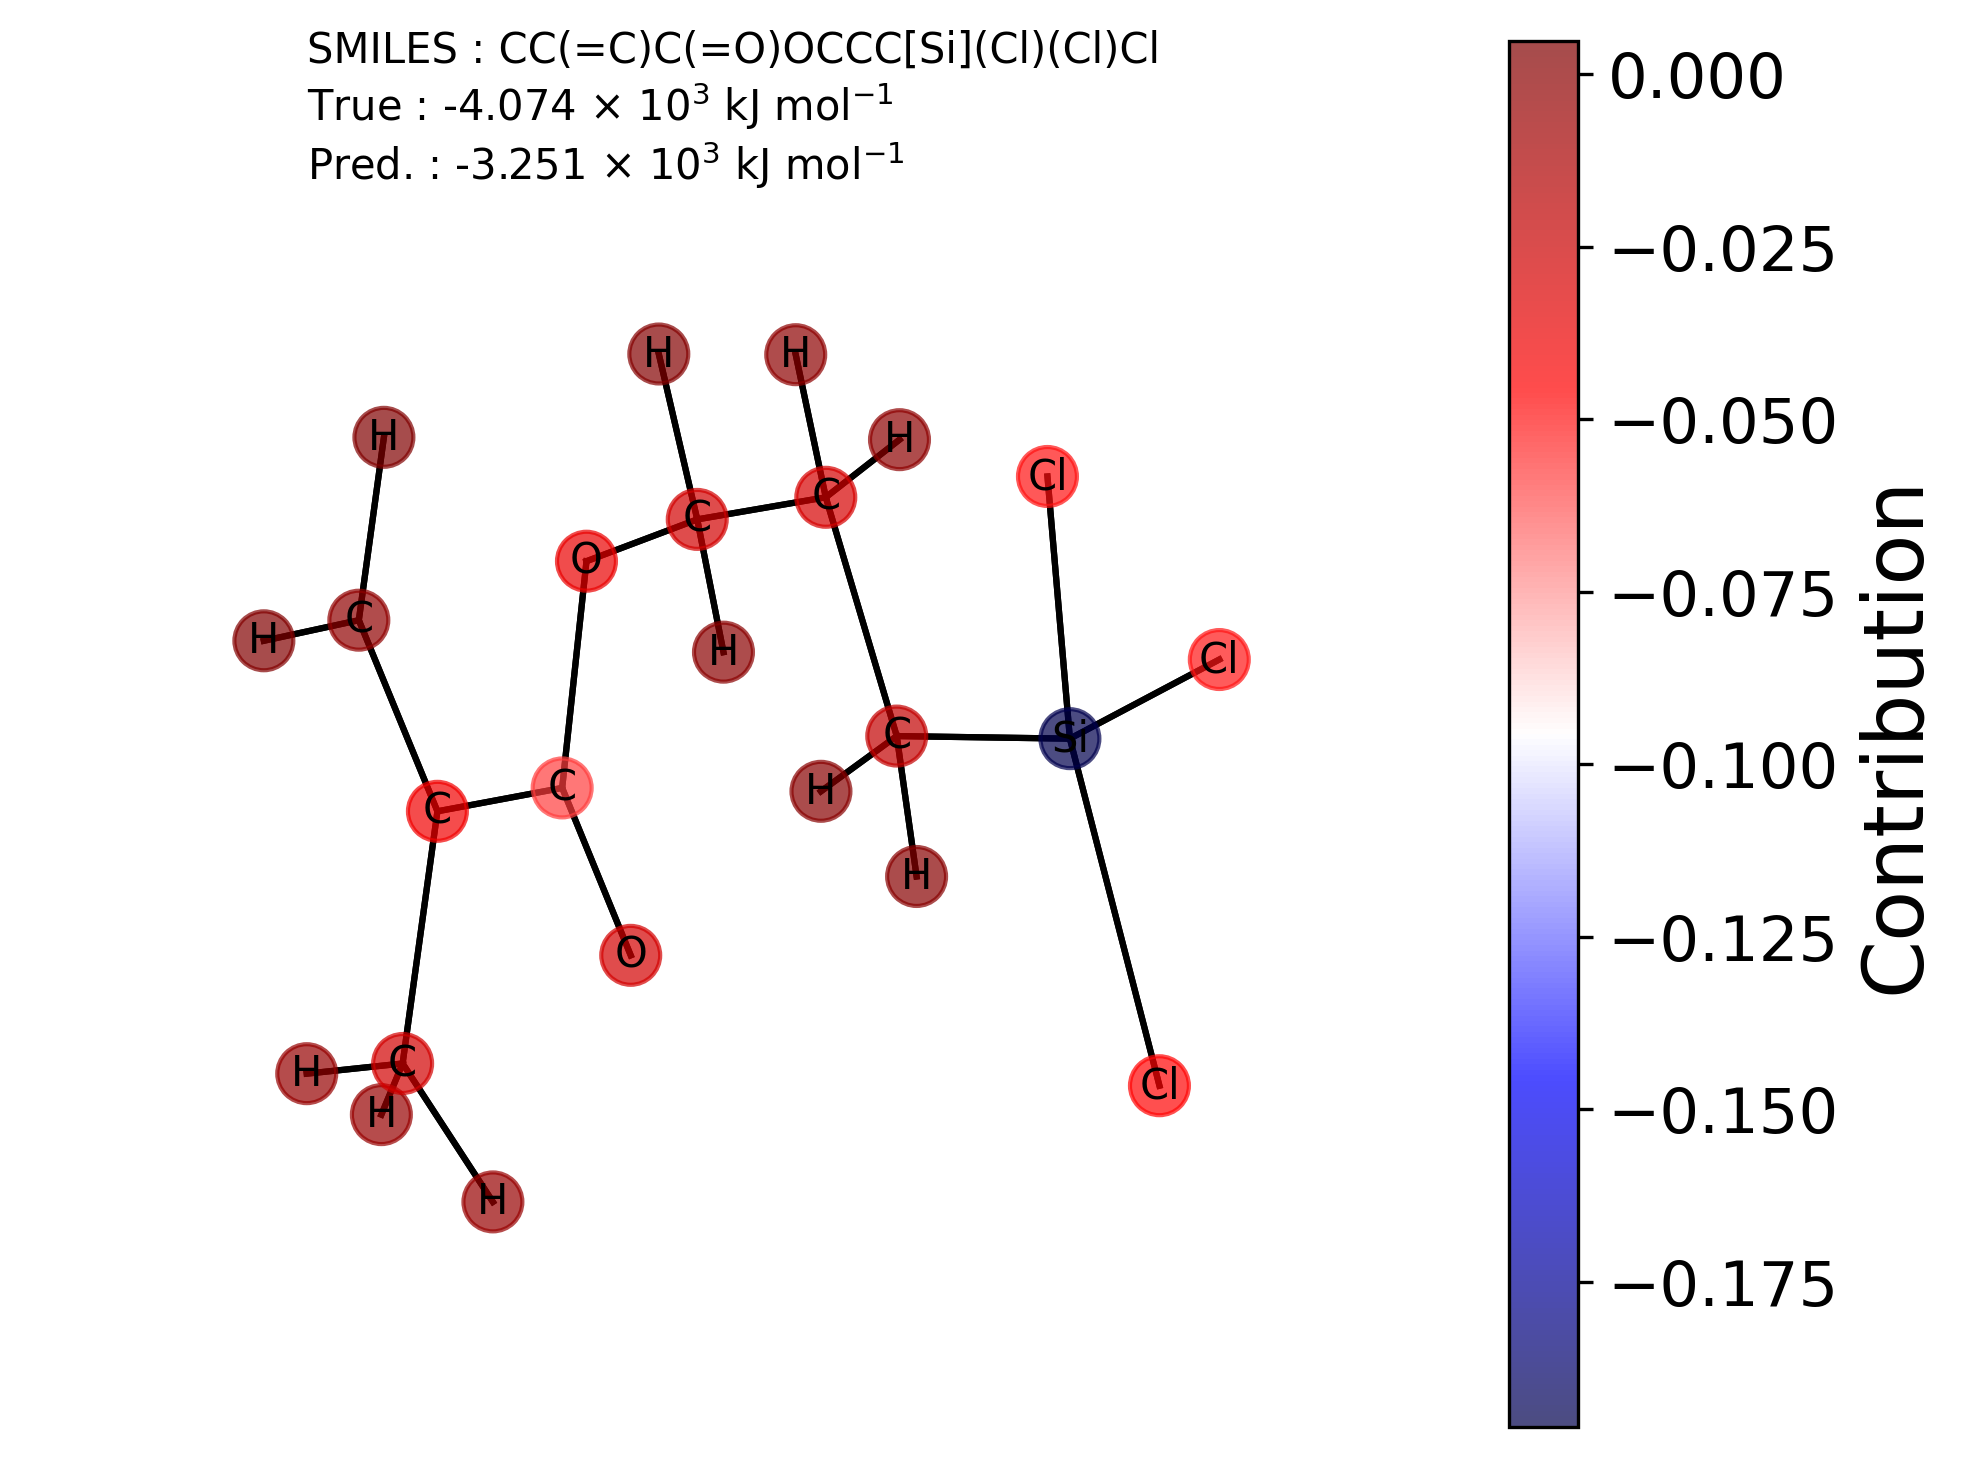

In [5]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize = (8, 6), dpi = 300,
                       subplot_kw = dict(projection = '3d'))

p = explainer.plot(ax)

ax.dist = 100

ax.view_init(azim = -100, elev = 73, roll = 0)
ax.set_box_aspect(None, zoom = 1.25)

cb = fig.colorbar(p)
cb.set_label("Contribution", fontsize = 20)
cb.ax.tick_params(labelsize = 15)

ax.annotate(
    r"""SMILES : %s
True : %.03f $\times$ 10$^3$ kJ mol$^{-1}$
Pred. : %.03f $\times$ 10$^3$ kJ mol$^{-1}$""" % (SMILES, TRUE_VAL, pred),
    xy = (0.2, 0.9), xycoords = 'axes fraction', fontsize = 10,
)

plt.savefig(f"./explain_results/{parameters['target']}_{SMILES}.png", dpi = 300)
plt.show()